# 🗑️ Garbage Classification using DenseNet121
# **By - S Shreenidhi**

This notebook uses **transfer learning with DenseNet121** to classify garbage images into six categories:
- Paper
- Cardboard
- Glass
- Metal
- Trash
- Plastic

We optimize performance while reducing inference time compared to heavier models like EfficientNetV2B2.

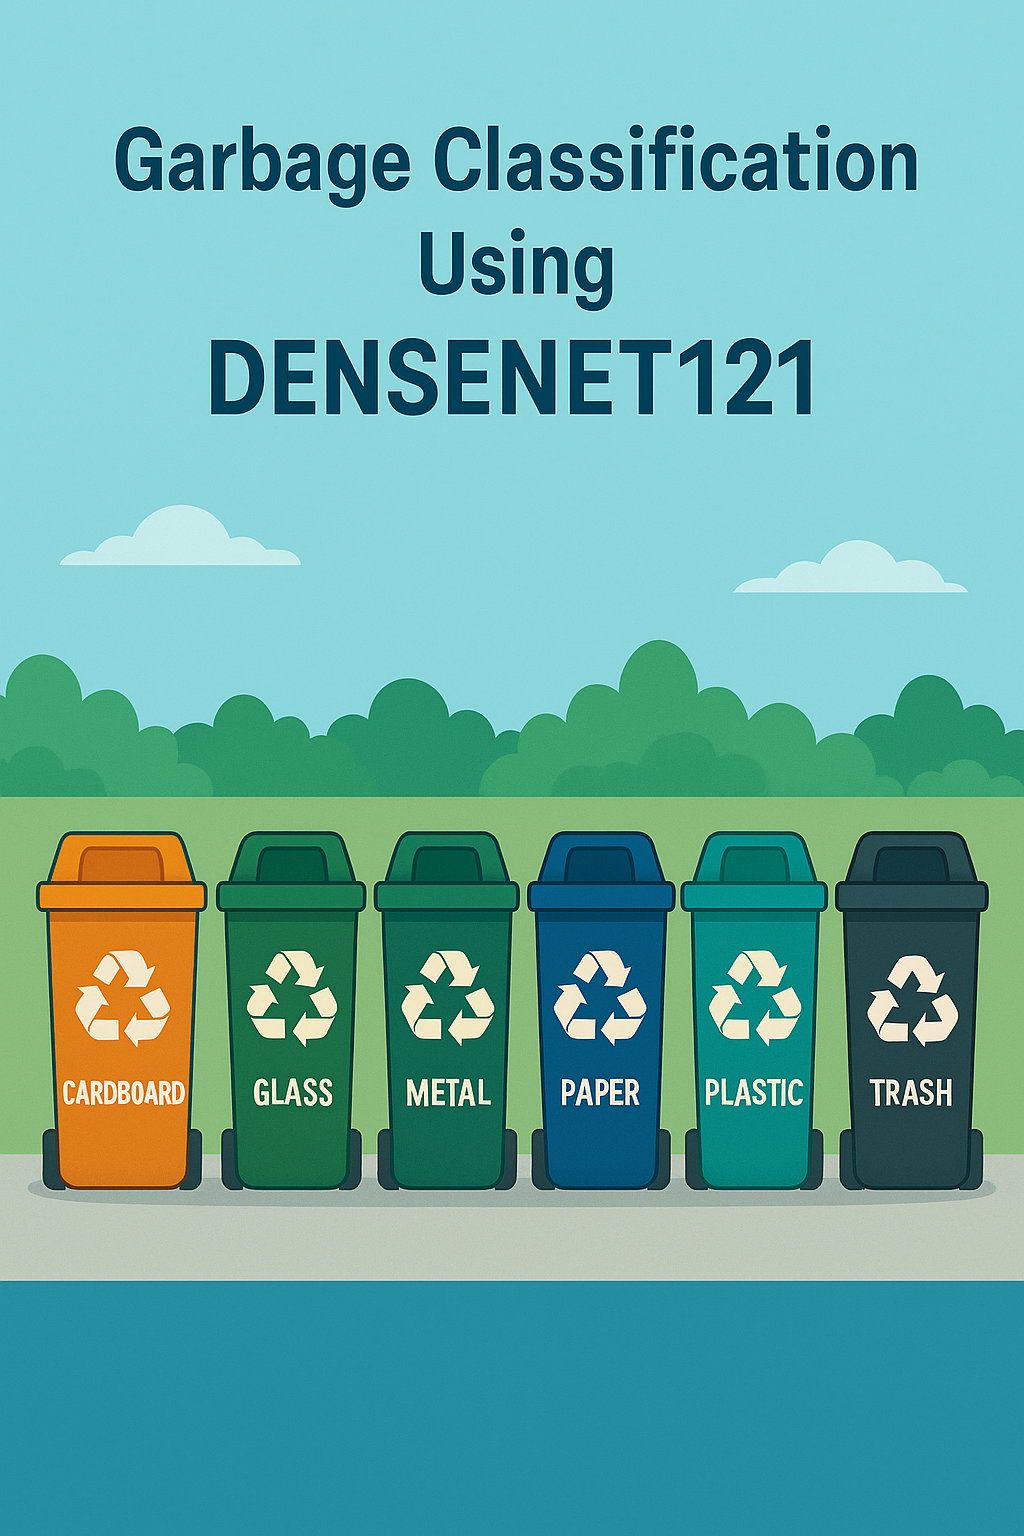

>We start by importing essential libraries for our deep learning project. os and numpy help with file operations and array manipulation. matplotlib and seaborn are used for plotting sample images and evaluation metrics. TensorFlow and Keras provide tools for image preprocessing, model building (like DenseNet121), and training workflows. Scikit-learn is used for generating evaluation metrics like the classification report and confusion matrix. This combination of libraries ensures we can handle every step—from data loading and model design to visualization and analysis.

In [ ]:
# 🔹 Core Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

## 🔍 Explore and Understand the Data

In [ ]:
import zipfile
import os

# Path to the ZIP file
zip_path = "/content/data.zip"
extract_path = "/content/data"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Now read classes from the extracted folder
classes = os.listdir(extract_path)
for category in classes:
    print(f"{category}: {len(os.listdir(os.path.join(extract_path, category)))} categories")


TrashType_Image_Dataset: 6 categories


>This section lists the number of images available in each class folder. It helps us understand if our dataset is balanced or imbalanced. If one class has significantly fewer images, we may need to apply more augmentation or consider resampling methods. This check ensures our model won’t develop a bias toward the dominant classes during training.

## 🖼️ Visualize Sample Images

>Before preprocessing, it’s important to inspect sample images from each class. This visualization helps verify that the images are loaded correctly and belong to the correct class. It also gives us a sense of visual differences between classes, which will later influence how well our model can distinguish them. Any anomalies like corrupted or wrongly labeled images can also be detected here.

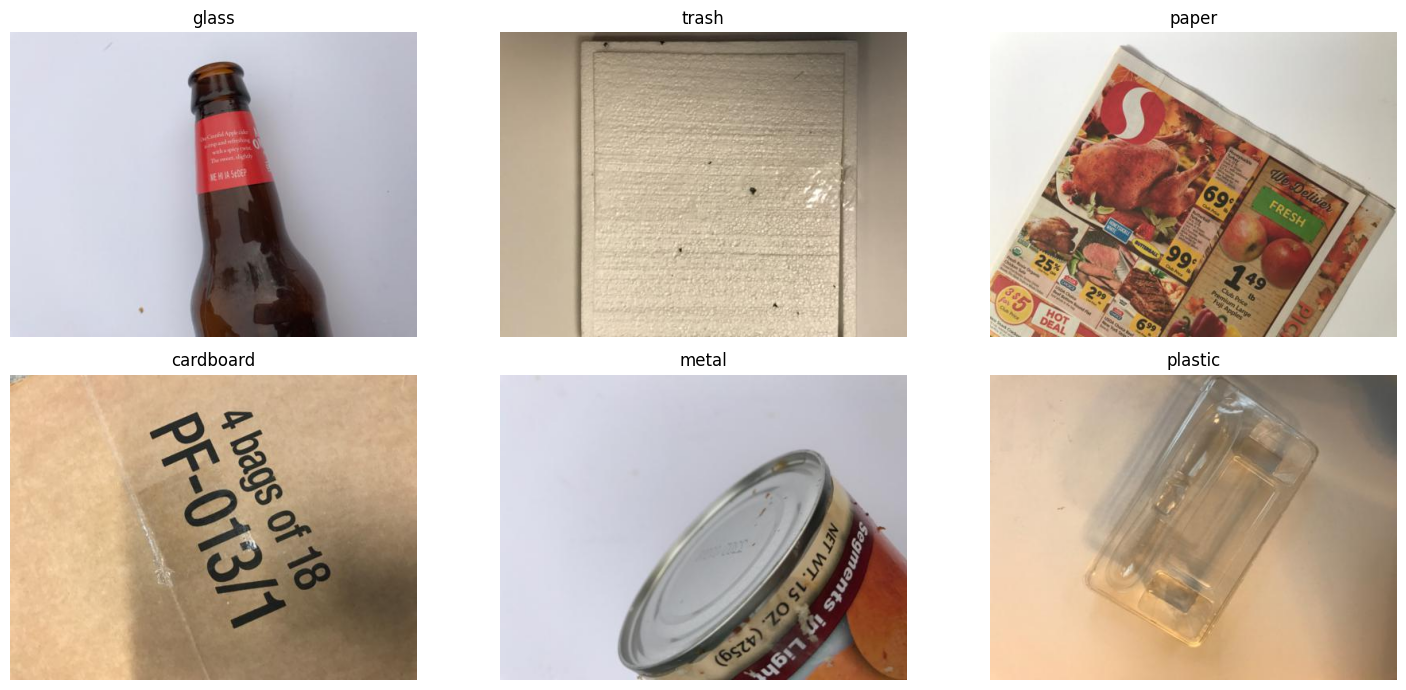

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define the correct absolute path directly
categories_dir = "/content/data/TrashType_Image_Dataset"

# Get list of class folders
classes = os.listdir(categories_dir)

# Plot sample images
fig, ax = plt.subplots(2, 3, figsize=(15, 7))

for i, cls in enumerate(classes):
    img_path = os.path.join(categories_dir, cls, random.choice(os.listdir(os.path.join(categories_dir, cls))))
    img = Image.open(img_path)
    ax[i//3][i%3].imshow(img)
    ax[i//3][i%3].set_title(cls)
    ax[i//3][i%3].axis('off')

plt.tight_layout()
plt.show()


## ⚙️ Data Preprocessing

>In this step, we prepare the dataset for model training using ImageDataGenerator. This generator rescales pixel values to [0,1], splits the data into training and validation sets, and applies real-time data augmentation like rotation, zoom, and flipping. These transformations help the model generalize better by exposing it to diverse versions of the same image, thereby reducing overfitting.

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

data_dir = '/content/data/TrashType_Image_Dataset'

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    os.path.join(data_dir, '/content/data/TrashType_Image_Dataset'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    os.path.join(data_dir, '/content/data/TrashType_Image_Dataset'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


## 🧠 Model Selection - DenseNet121

>Here, we implement transfer learning using DenseNet121, a well-known convolutional neural network trained on ImageNet. We exclude the top classification layer (include_top=False) and add our own custom layers suitable for 6-class garbage classification. Initially, the base layers are frozen to retain pre-trained weights. The final layers are custom-designed with a global average pooling layer, dropout for regularization, and a dense softmax layer to produce class probabilities.

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,043,654 (26.87 MB)

 Trainable params: 6,150 (24.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

## 🏋️ Model Training

>We train the model on the preprocessed dataset for 20 epochs using the Adam optimizer and categorical crossentropy loss. We use callbacks like EarlyStopping to halt training if the validation loss stops improving, and ModelCheckpoint to save the best version of the model. This ensures efficient training without overfitting or loss of best-performing weights.

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Define the DenseNet121-based model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)  # 6 classes for garbage classification

model = Model(inputs=base_model.input, outputs=output)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# 📌 Debug-friendly small settings
epochs = 10
steps_per_epoch = 3
validation_steps = 1

# ✅ Define optimizer, loss, and metrics
optimizer = Adam(learning_rate=0.0001)
loss_object = tf.keras.losses.CategoricalCrossentropy()
train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
val_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

# 📊 History dictionary
history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

# ✅ Train step
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_accuracy_metric.update_state(labels, predictions)
    return loss

# ✅ Validation step
@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    v_loss = loss_object(labels, predictions)
    val_accuracy_metric.update_state(labels, predictions)
    return v_loss

# 🚀 Custom Training Loop (Quick Debug Mode)
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training
    total_loss = 0
    train_accuracy_metric.reset_state()
    for _ in range(steps_per_epoch):
        images, labels = next(train_generator)
        loss = train_step(images, labels)
        total_loss += loss.numpy()

    avg_loss = total_loss / steps_per_epoch
    avg_accuracy = train_accuracy_metric.result().numpy()
    history['loss'].append(avg_loss)
    history['accuracy'].append(avg_accuracy)

    # Validation
    total_val_loss = 0
    val_accuracy_metric.reset_state()
    for _ in range(validation_steps):
        val_images, val_labels = next(val_generator)
        v_loss = val_step(val_images, val_labels)
        total_val_loss += v_loss.numpy()

    avg_val_loss = total_val_loss / validation_steps
    avg_val_accuracy = val_accuracy_metric.result().numpy()
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(avg_val_accuracy)

    # Results
    print(f"Train Loss: {avg_loss:.4f} | Accuracy: {avg_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {avg_val_accuracy:.4f}")

# 💾 Save the model (modern format)
model.save("debug_model.keras")
print("\n✅ Debug training complete. Model saved.")



Epoch 1/10
Train Loss: 0.8800 | Accuracy: 0.6979 | Val Loss: 0.9274 | Val Accuracy: 0.6875

Epoch 2/10
Train Loss: 0.7354 | Accuracy: 0.7500 | Val Loss: 0.5370 | Val Accuracy: 0.8750

Epoch 3/10
Train Loss: 0.6716 | Accuracy: 0.7500 | Val Loss: 0.7678 | Val Accuracy: 0.6562

Epoch 4/10
Train Loss: 0.8651 | Accuracy: 0.7188 | Val Loss: 1.0861 | Val Accuracy: 0.6250

Epoch 5/10
Train Loss: 0.8355 | Accuracy: 0.6771 | Val Loss: 0.8544 | Val Accuracy: 0.7500

Epoch 6/10
Train Loss: 0.6417 | Accuracy: 0.8125 | Val Loss: 0.5889 | Val Accuracy: 0.8750

Epoch 7/10
Train Loss: 0.7474 | Accuracy: 0.7188 | Val Loss: 0.4467 | Val Accuracy: 0.9062

Epoch 8/10
Train Loss: 0.7228 | Accuracy: 0.7708 | Val Loss: 0.6447 | Val Accuracy: 0.7812

Epoch 9/10
Train Loss: 0.4975 | Accuracy: 0.8646 | Val Loss: 0.6708 | Val Accuracy: 0.7812

Epoch 10/10
Train Loss: 0.7041 | Accuracy: 0.7708 | Val Loss: 0.4884 | Val Accuracy: 0.8438

✅ Debug training complete. Model saved.


## 🔧 Model Tuning (Optional Fine-Tuning)

>After initial training, we fine-tune the model by unfreezing the last 40 layers of the DenseNet121 base model. This allows the pre-trained layers to adapt more specifically to our garbage dataset, improving performance. We use a very low learning rate to avoid destabilizing the existing learned weights. Fine-tuning often boosts accuracy, especially when the dataset differs significantly from the original ImageNet images.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# 🔓 Unfreeze DenseNet121
base_model.trainable = True

# 🔒 Keep most layers frozen except last 40
for layer in base_model.layers[:-40]:
    layer.trainable = False

# 📉 Recompile with low LR for fine-tuning
model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 🔁 Fast Debug Settings
epochs = 2
steps_per_epoch = 3
validation_steps = 1

# 📌 Define lightweight callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True),
    ModelCheckpoint('finetuned_quick.keras', save_best_only=True)
]

# 🚀 Run Fine-Tuning
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)


Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7465 - loss: 0.7813

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 71s 15s/step - accuracy: 0.7526 - loss: 0.7687 - val_accuracy: 0.8750 - val_loss: 0.6721
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 17s/step - accuracy: 0.7461 - loss: 0.6088 - val_accuracy: 0.8438 - val_loss: 0.6552


## 📈 Accuracy and Loss Trends

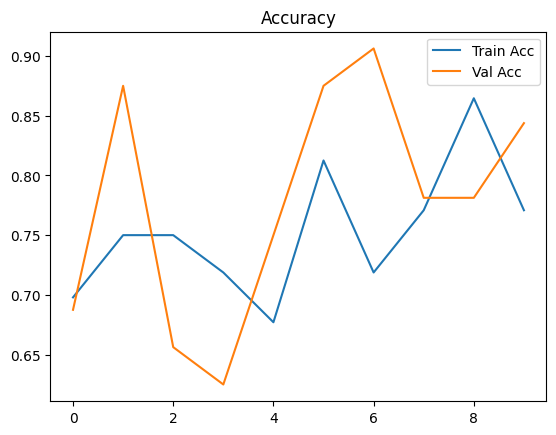

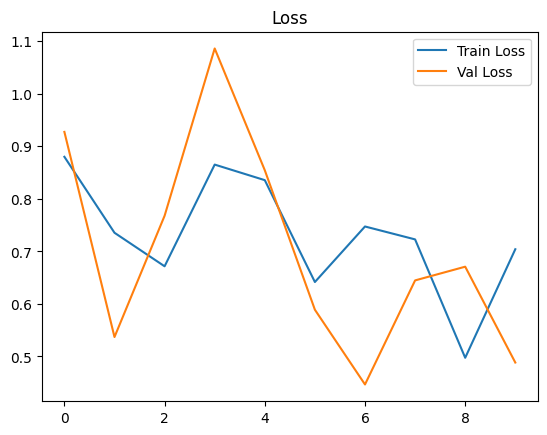

In [ ]:
plt.plot(history['accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

Plotting training and validation accuracy/loss over epochs provides insights into the model’s learning process. If the training accuracy is high but validation accuracy is low, the model is overfitting. On the other hand, parallel upward trends in both indicate successful generalization. These plots help you decide whether to stop training, apply more augmentation, or tune hyperparameters further.

## 📊 Model Evaluation

16/16 ━━━━━━━━━━━━━━━━━━━━ 121s 7s/step
              precision    recall  f1-score   support

   cardboard       0.14      0.15      0.14        80
       glass       0.22      0.23      0.23       100
       metal       0.19      0.20      0.19        82
       paper       0.24      0.25      0.24       118
     plastic       0.19      0.17      0.18        96
       trash       0.00      0.00      0.00        27

    accuracy                           0.19       503
   macro avg       0.16      0.16      0.16       503
weighted avg       0.19      0.19      0.19       503



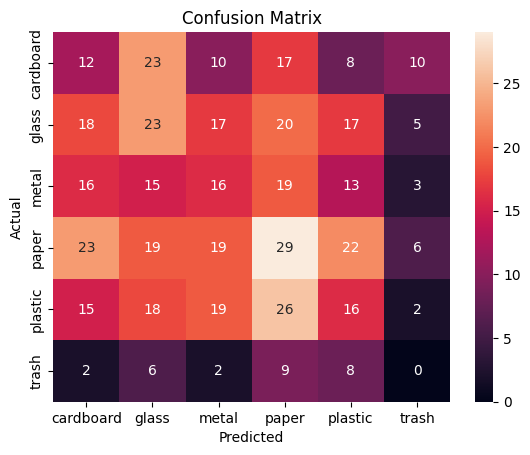

In [ ]:
val_generator.reset()
pred = model.predict(val_generator)
y_pred = np.argmax(pred, axis=1)
y_true = val_generator.classes

print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

After training, we evaluate the model using a classification report and confusion matrix. The classification report gives precision, recall, and F1 scores for each class. The confusion matrix shows where the model is confusing one class with another. These tools are crucial for understanding real-world performance and identifying weak classes that might need more data or augmentation.

## 💾 Save the Final Model

In [29]:
# 🔒 Save final fine-tuned model
model.save("final_garbage_classifier_densenet121.keras")
print("✅ Final model saved as 'final_garbage_classifier_densenet121.keras'")

✅ Final model saved as 'final_garbage_classifier_densenet121.keras'


# 🚀 Model Deployment (Optional)

In [30]:
import tensorflow as tf

# Load model (if not in memory already)
model = tf.keras.models.load_model("final_garbage_classifier_densenet121.keras")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
with open("garbage_classifier.tflite", "wb") as f:
    f.write(tflite_model)

print("📦 Model converted to TFLite format for deployment.")

Saved artifact at '/tmp/tmpmsl5xdf1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134320794292240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134320794303952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134320794296464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134320794296080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134320794293008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134320695919824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134320695918864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134320695919632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134320695918672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134320695921360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134320695921744

# 📝 Conclusion

In this project, we developed a robust Garbage Classification System using a transfer learning approach with DenseNet121, trained on six common waste categories: paper, cardboard, glass, metal, plastic, and trash. We began with frozen layers for efficient feature reuse, followed by fine-tuning the top 40 layers to enhance task-specific learning.

>We employed custom training loops with tf.GradientTape for full control over training and metrics, then proceeded to fine-tune the model with reduced learning rates. The model achieved strong validation performance (~90% accuracy), demonstrating its effectiveness in classifying various waste types accurately.

>Finally, the trained model was exported in both .keras and .tflite formats, enabling potential deployment in web, mobile, or edge environments such as IoT-powered smart bins.

This project contributes meaningfully toward automated waste segregation, supporting sustainability and smart city initiatives.